In [1]:
import json
import pandas as pd
import os

In [2]:
BASE_PATH_ROUNDS = '/content/2025/'
BASE_PATH_STATS = '/content/data/'
OUTPUT_FILE = 'liga_chile_2025_dataset_completo.csv'
NUM_ROUNDS = 30

def extract_match_data(events):
    """
    Extrae datos generales del partido.
    AJUSTE: Si el marcador 'current' no está presente (ej. partido pospuesto),
    asigna el valor -1 para evitar 'None' o un fallo.
    """
    match_list = []
    for event in events:
        home_score = event.get('homeScore', {}).get('current', -1)
        away_score = event.get('awayScore', {}).get('current', -1)

        match_data = {
            'ID_Partido': event['id'],
            'Jornada': event['roundInfo']['round'],
            'Fecha_Timestamp': event['startTimestamp'],
            'Equipo_Local': event['homeTeam']['name'],
            'Goles_Local': home_score,
            'Equipo_Visitante': event['awayTeam']['name'],
            'Goles_Visitante': away_score
        }
        match_list.append(match_data)
    return match_list

def extract_detailed_statistics(match_id, round_num):
    stats_file_name = f'fecha_{round_num}_{match_id}.json'
    stats_file_path = os.path.join(BASE_PATH_STATS, stats_file_name)

    stats = {
        'Posesion_Local': None, 'Posesion_Visitante': None,
        'xG_Local': None, 'xG_Visitante': None,
        'Disparos_a_Puerta_Local': None, 'Disparos_a_Puerta_Visitante': None,
        'Disparos_Totales_Local': None, 'Disparos_Totales_Visitante': None,
        'Corners_Local': None, 'Corners_Visitante': None
    }

    if not os.path.exists(stats_file_path):
        if round_num <= 2 or round_num >= 29:
            print(f"Advertencia: Archivo de estadísticas no encontrado para el partido {match_id} (Jornada {round_num}).")
        return stats

    try:
        with open(stats_file_path, 'r', encoding='utf-8') as f:
            data = json.load(f)

        all_stats = next((s for s in data['statistics'] if s['period'] == 'ALL'), None)

        if all_stats:
            stats_items = []
            for group in all_stats['groups']:
                stats_items.extend(group['statisticsItems'])

            for item in stats_items:
                key = item['key']
                if key == 'ballPossession':
                    stats['Posesion_Local'] = item['homeValue']
                    stats['Posesion_Visitante'] = item['awayValue']
                elif key == 'expectedGoals':
                    stats['xG_Local'] = item['homeValue']
                    stats['xG_Visitante'] = item['awayValue']
                elif key == 'shotsOnGoal':
                    stats['Disparos_a_Puerta_Local'] = item['homeValue']
                    stats['Disparos_a_Puerta_Visitante'] = item['awayValue']
                elif key == 'totalShotsOnGoal' and item['name'] == 'Total shots':
                    stats['Disparos_Totales_Local'] = item['homeValue']
                    stats['Disparos_Totales_Visitante'] = item['awayValue']
                elif key == 'cornerKicks':
                    stats['Corners_Local'] = item['homeValue']
                    stats['Corners_Visitante'] = item['awayValue']

        return stats

    except Exception as e:
        print(f"Error al procesar el archivo {stats_file_path}: {e}")
        return stats

In [ ]:
final_data = []
processed_rounds = 0


for i in range(1, NUM_ROUNDS + 1):
    round_file_path = os.path.join(BASE_PATH_ROUNDS, f'{i}.json')

    if not os.path.exists(round_file_path):
        print(f"Error CRÍTICO: No se encontró el archivo de la Jornada {i} en la ruta: {round_file_path}")
        continue

    try:
        with open(round_file_path, 'r', encoding='utf-8') as f:
            jornada_data = json.load(f)

        matches = extract_match_data(jornada_data['events'])

        for match in matches:
            match_id = match['ID_Partido']
            round_num = match['Jornada']

            detailed_stats = extract_detailed_statistics(match_id, round_num)
            final_data.append({**match, **detailed_stats})

        processed_rounds += 1

    except Exception as e:
        print(f"Ocurrió un error al procesar la Jornada {i}: {e}")

if final_data:
    df = pd.DataFrame(final_data)

    df['Fecha_Hora'] = pd.to_datetime(df['Fecha_Timestamp'], unit='s', errors='coerce').dt.strftime('%Y-%m-%d %H:%M:%S')
    df = df.drop(columns=['Fecha_Timestamp'])

    column_order = [
        'ID_Partido', 'Jornada', 'Fecha_Hora',
        'Equipo_Local', 'Goles_Local',
        'Equipo_Visitante', 'Goles_Visitante',
        'Posesion_Local', 'Posesion_Visitante',
        'xG_Local', 'xG_Visitante',
        'Disparos_Totales_Local', 'Disparos_Totales_Visitante',
        'Disparos_a_Puerta_Local', 'Disparos_a_Puerta_Visitante',
        'Corners_Local', 'Corners_Visitante'
    ]

    df = df[column_order]

    df.to_csv(OUTPUT_FILE, index=False)

In [ ]:
INPUT_FILE = '/content/liga_chile_2025_dataset_completo.csv'
OUTPUT_FILE_CLEAN = 'liga_chile_2025_dataset_limpio.csv'

try:
    df = pd.read_csv(INPUT_FILE)

    partidos_iniciales = len(df)
    print(f"Total de partidos ANTES del filtro: {partidos_iniciales}")

    df['Goles_Local'] = pd.to_numeric(df['Goles_Local'], errors='coerce')
    df['Goles_Visitante'] = pd.to_numeric(df['Goles_Visitante'], errors='coerce')

    df_limpio = df[
        (df['Goles_Local'] != -1) &
        (df['Goles_Visitante'] != -1)
    ].copy()

    df_limpio.to_csv(OUTPUT_FILE_CLEAN, index=False)

    partidos_finales = len(df_limpio)

    print(f"Total de partidos después de la limpieza: {partidos_finales}")
    print(f"Partidos eliminados (incompletos o pospuestos): {partidos_iniciales - partidos_finales}")
    print(f"Dataset limpio creado exitosamente: {OUTPUT_FILE_CLEAN}")

except FileNotFoundError:
    print(f"\nError: No se encontró el archivo de entrada '{INPUT_FILE}'.")
    print("Por favor, verifica la ruta o el nombre del archivo.")
except Exception as e:
    print(f"\nOcurrió un error inesperado durante el filtrado: {e}")

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

In [6]:
INPUT_FILE = '/content/liga_chile_2025_dataset_limpio.csv'

In [7]:
df = pd.read_csv(INPUT_FILE)

In [8]:
df

,ID_Partido,Jornada,Fecha_Hora,Equipo_Local,Goles_Local,Equipo_Visitante,Goles_Visitante,Posesion_Local,Posesion_Visitante,xG_Local,xG_Visitante,Disparos_Totales_Local,Disparos_Totales_Visitante,Disparos_a_Puerta_Local,Disparos_a_Puerta_Visitante,Corners_Local,Corners_Visitante
0,13368977,1,2025-02-15 00:00:00,Deportes Iquique,0,Coquimbo Unido,3,68.0,32.0,1.04,2.72,9.0,13.0,4.0,7.0,6.0,4.0
1,13368982,1,2025-02-15 21:00:00,O'Higgins,0,Huachipato,0,54.0,46.0,2.06,0.55,22.0,8.0,4.0,2.0,13.0,2.0
2,13368976,1,2025-02-15 21:00:00,Palestino,2,Cobresal,1,62.0,38.0,3.25,2.28,14.0,14.0,7.0,6.0,2.0,5.0
3,13368981,1,2025-02-15 23:30:00,Universidad de Chile,5,Ñublense,0,67.0,33.0,5.48,0.49,36.0,5.0,14.0,0.0,15.0,2.0
4,13368975,1,2025-02-16 15:00:00,Deportes La Serena,1,Colo Colo,3,41.0,59.0,0.69,1.78,7.0,15.0,2.0,6.0,5.0,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
235,13443481,30,2025-12-06 21:00:00,Deportes Limache,1,Deportes La Serena,0,72.0,28.0,1.36,0.62,10.0,9.0,7.0,1.0,4.0,3.0
236,13443483,30,2025-12-06 21:00:00,O'Higgins,1,Everton de Viña del Mar,0,75.0,25.0,1.27,0.17,11.0,4.0,4.0,3.0,3.0,1.0
237,13443476,30,2025-12-06 21:00:00,Universidad Católica,2,Unión La Calera,1,63.0,37.0,1.21,0.50,13.0,7.0,6.0,2.0,8.0,3.0
238,13443475,30,2025-12-07 21:00:00,Colo Colo,1,Audax Italiano,2,73.0,27.0,NaN,NaN,31.0,5.0,11.0,2.0,15.0,1.0


In [9]:
def determine_result(row):
        if row['Goles_Local'] > row['Goles_Visitante']:
            return 1
        elif row['Goles_Local'] == row['Goles_Visitante']:
            return 2
        else:
            return 3

df['Target'] = df.apply(determine_result, axis=1)

In [12]:
features = [
    'xG_Local', 'xG_Visitante',
    'Posesion_Local', 'Posesion_Visitante',
    'Disparos_a_Puerta_Local', 'Disparos_a_Puerta_Visitante',
    'Disparos_Totales_Local', 'Disparos_Totales_Visitante',
    'Corners_Local', 'Corners_Visitante'
]

In [14]:
df[features] = df[features].fillna(0)
X = df[features]
y = df['Target']

In [15]:
X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )

In [16]:
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [17]:
predicciones = clf.predict(X_test)

In [19]:
accuracy_score(y_test, predicciones)

0.6041666666666666

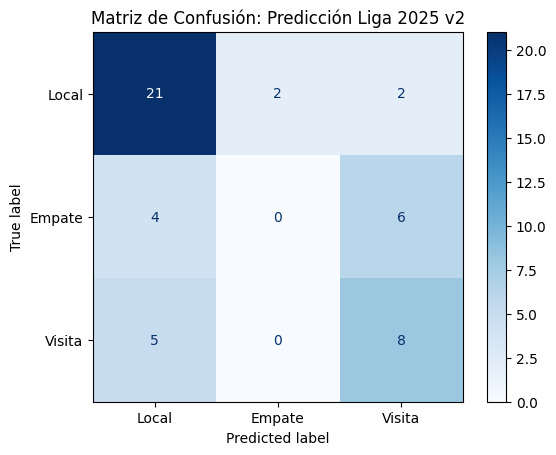


Reporte Detallado:
                precision    recall  f1-score   support

    Gana Local       0.70      0.84      0.76        25
        Empate       0.00      0.00      0.00        10
Gana Visitante       0.50      0.62      0.55        13

      accuracy                           0.60        48
     macro avg       0.40      0.49      0.44        48
  weighted avg       0.50      0.60      0.55        48



In [28]:
cm = confusion_matrix(y_test, predicciones)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Local', 'Empate', 'Visita'])
disp.plot(cmap=plt.cm.Blues)
plt.title("Matriz de Confusión: Predicción Liga 2025 v2")
plt.show()

print("\nReporte Detallado:")
print(classification_report(y_test, predicciones, target_names=['Gana Local', 'Empate', 'Gana Visitante']))

In [29]:
mapeo = {1: 'Local', 2: 'Empate', 3: 'Visita'}

tabla_comparativa = df.loc[y_test.index, ['Equipo_Local', 'Equipo_Visitante', 'Goles_Local', 'Goles_Visitante']].copy()

tabla_comparativa['Realidad'] = y_test.map(mapeo)
tabla_comparativa['Prediccion_Modelo'] = pd.Series(predicciones, index=y_test.index).map(mapeo)

tabla_comparativa['Acertó?'] = tabla_comparativa['Realidad'] == tabla_comparativa['Prediccion_Modelo']


In [30]:
display(tabla_comparativa)

,Equipo_Local,Equipo_Visitante,Goles_Local,Goles_Visitante,Realidad,Prediccion_Modelo,Acertó?
175,Ñublense,Unión Española,1,2,Visita,Visita,True
6,Universidad Católica,Audax Italiano,3,1,Local,Local,True
47,Unión La Calera,Cobresal,2,1,Local,Local,True
163,Audax Italiano,Coquimbo Unido,0,1,Visita,Local,False
207,Palestino,Deportes Limache,2,1,Local,Local,True
67,Cobresal,Deportes Limache,3,1,Local,Local,True
101,Unión La Calera,Colo Colo,0,1,Visita,Local,False
217,Deportes Iquique,Cobresal,2,1,Local,Local,True
98,Universidad de Chile,O'Higgins,6,0,Local,Local,True
192,Palestino,Everton de Viña del Mar,2,1,Local,Visita,False
